In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df_train=pd.read_csv(r"C:\Users\yuto sawa\Documents\kaggle_data\houseprice/train.csv")
df_test=pd.read_csv(r"C:\Users\yuto sawa\Documents\kaggle_data\houseprice/test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D9B0E45400>]],
      dtype=object)

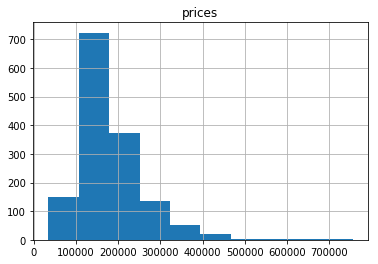

In [4]:
df=pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))

#check the skewness
prices=pd.DataFrame({'prices':df_train['SalePrice']})
prices.hist()

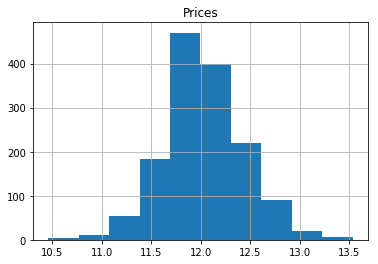

In [5]:
#log transformation
df_train['SalePrice']=np.log1p(df_train['SalePrice'])
prices=pd.DataFrame({'Prices':df_train['SalePrice']})
prices.hist()

numeric_data=df.dtypes[df.dtypes!=object].index
skewed_feats=df_train[numeric_data].apply(lambda x: skew(x.dropna()))
skewed_feats=skewed_feats[skewed_feats > 0.75 ]
skewed_feats=skewed_feats.index

df[skewed_feats]=np.log1p(df[skewed_feats])

In [6]:
df=pd.get_dummies(df, drop_first=True)

In [7]:
#filling NAs with the mean of the columns
df=df.fillna(df.mean())

In [8]:
#creating matrixes for sklearn
X_train=df[:df_train.shape[0]]
X_test=df[df_train.shape[0]:]
y=df_train['SalePrice']

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

def rmse_cv(model):
    rmse=np.sqrt(-cross_val_score(model, X_train, y, 
                                  scoring='neg_mean_squared_error', cv=5))
    return(rmse)



0.12831170209125167

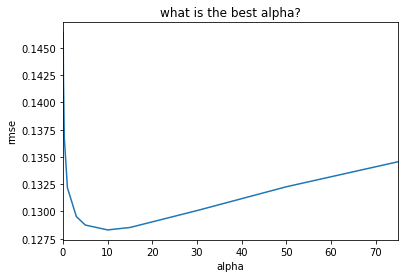

In [13]:
#serch the best alpha of Ridge model
model_ridge=Ridge()
alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge=[rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge=pd.Series(cv_ridge,index=alphas)
cv_ridge.plot(title="what is the best alpha?")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

In [22]:
#Using Lasso model
model_lasso=LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()



0.12704705593261428

Lasso model finds out to be better.

In [25]:
#make a prediction
test_id=df_test['Id']
pred=model_lasso.predict(X_test)
y_pred=np.exp(pred)

submission=pd.DataFrame({'id':test_id, 'SalePrice':y_pred})
submission.to_csv(r'C:\Users\yuto sawa\Documents\kaggle_data\houseprice/house_submission2.csv',index=False)